<a href="https://www.kaggle.com/code/owaiskhan9654/training-of-customized-urbansound8k-multi-labeled?scriptVersionId=179603063" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **<span style="color:#F32321;">Connect on Linkedin if you have any doubts**</span> - [Contact](https://www.linkedin.com/in/owaiskhan9654/)

# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:75%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Training of Customized UrbanSound8K Multi Labeled Audio Data.<br><br> This Notebook is Highly Motivated by Jackson Goode's work <a href="https://jacksongoo.de/about/">Link</a>.</div>

<p style="line-height: 1.7;color: #666;font-weight: 600;margin-bottom: 20px;letter-spacing: 0.4px;"><a href="https://urbansounddataset.weebly.com/urbansound8k.html">UrbanSound8K</a> contains over 8000 sound files separated by categories of sounds typically found in an urban setting. Instead of exclusive categorical labels in its original state, the dataset has been recreated with the purpose of exploring how a successful architecture might perform on multi-label samples rather than simply uni-label, multi-class sounds. Thus, this notebook investigates how techniques in classifying an environmental noise data might generalize to a <b>Multi-Label scenario with a new Audio data </b>composed of overlaid sound pairs.
</p>

<h2 style="line-height: 1.7;color: #666;font-weight: 600;margin-bottom: 20px;letter-spacing: 0.4px;">Overview of dataset and fabrication</h2>
<p style="line-height: 1.7;color: #666;font-weight: 600;margin-bottom: 20px;letter-spacing: 0.4px;">The original dataset, UrbanSound8K, contains 8732 .wav sounds sourced from Freesound.org across 10 classes of urban sounds:</p>
<ol style="display: block;list-style-type: decimal;font-weight: 500; margin-block-start: 1em;margin-block-end: 1em;margin-inline-start: 0px; margin-inline-end: 0px;padding-inline-start: 40px;color: #666">
<li>Air Conditioner</li>
<li>Car Horn</li>
<li>Children Playing</li>
<li>Dog Bark</li>
<li>Drilling</li>
<li>Engine Idling</li>
<li>Gun Shot</li>
<li>Jackhammer</li>
<li>Siren</li>
<li>Street Music</li>
</ol>
<p style="line-height: 1.7;color: #666;font-weight: 600;margin-bottom: 20px;letter-spacing: 0.4px;">All are separated into 10 folds (each containing an equal distribution selection of the classes). These sounds are all less than 4s but vary in length, recording device, sample rate and perceptual loudness. Many of the sounds were generated as slices from longer sounds - meaning that many sounds share the same sound file source.</p>
<p style="line-height: 1.7;color: #666;font-weight: 600;margin-bottom: 20px;letter-spacing: 0.4px;">For creating a new dataset, composition of multiple tracks of audio from UrbanSound8K. Using the library pydub he created a separate script to use a randomized list of each fold’s files and overplayed each file with a randomized gain reduction between -6 and 0. This enabled a more authentic mixture of sound in a live context and would also contribute to the robustness of the model and its consequent difficulty during training (10 classes to 45 conceptual classes (or 10 choose 2)).</p>


 <h2 style="line-height: 1.7;color: #666;font-weight: 600;margin-bottom: 20px;letter-spacing: 0.4px;"> This Notebook is Rebuild version by <a href="https://www.linkedin.com/in/owaiskhan9654/">Owais Ahmad</a> for training of Multi-Labeled audio data processed from orignal audios taken from UrbanSound8K.</h2>
<ol style="display: block;list-style-type: decimal;font-weight: 500; margin-block-start: 1em;margin-block-end: 1em;margin-inline-start: 0px; margin-inline-end: 0px;padding-inline-start: 40px;color: #666">

<br>
<br>

> 
> <p style="line-height: 1.7;color: #666;font-weight: 600;margin-bottom: 20px;letter-spacing: 0.4px;">I have integrated W&B for visualizations and logging artifacts here in below link!</p>
> <p style="line-height: 1.7;color: #666;font-weight: 600;margin-bottom: 20px;letter-spacing: 0.4px;"> <a href="https://wandb.ai/owaiskhan9515/Training%20of%20Customized%20UrbanSound8K%20Multi%20Labeled%20Audio%20Data">Training of Customized UrbanSound8K Multi Labeled Audio Data</a></p>


> - <p style="line-height: 1.7;color: #666;font-weight: 600;margin-bottom: 20px;letter-spacing: 0.4px;">To get the API key, create an account in the <a href="https://wandb.ai/site">website.</a></p>
> - <p style="line-height: 1.7;color: #666;font-weight: 600;margin-bottom: 20px;letter-spacing: 0.4px;">Use secrets to use API Keys more securely </p>

In [1]:
!nvidia-smi # 2 GPUs available in Kaggle 

Fri May 24 20:38:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%%capture
!pip install wandb --upgrade

In [3]:
import os
import sys 
import time
import random
import glob
import csv
from ast import literal_eval

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display
plt.figure(figsize=(12, 4))

import wandb
# from wandb.keras import WandbCallback
from wandb.integration.keras import WandbMetricsLogger
from kaggle_secrets import UserSecretsClient

from pydub import AudioSegment, effects
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, hamming_loss, multilabel_confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

<Figure size 864x288 with 0 Axes>

In [4]:
try:
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("wandb_api")
    wandb.login(key=secret_value_0)
    anony=None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    
wandb.init(project="Training of Customized UrbanSound8K Multi Labeled Audio Data",name=f"16.Training of Customized UrbanSound8K-Run-16")


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: owaiskhan9515. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240524_203846-cflgqje9
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run 16.Training of Customized UrbanSound8K-Run-16
wandb: ⭐️ View project at https://wandb.ai/owaiskhan9515/Training%20of%20Customized%20UrbanSound8K%20Multi%20Labeled%20Audio%20Data
wandb: 🚀 View run at https://wandb.ai/owaiskhan9515/Training%20of%20Customized%20UrbanSound8K%20Multi%20Labeled%20Audio%20Data/runs/cflgqje9


In [5]:
!mkdir /kaggle/working/multi/
!mkdir /kaggle/working/multi/fold1

!mkdir /kaggle/working/multi/fold2

!mkdir /kaggle/working/multi/fold3

!mkdir /kaggle/working/multi/fold4

!mkdir /kaggle/working/multi/fold5

!mkdir /kaggle/working/multi/fold6

!mkdir /kaggle/working/multi/fold7

!mkdir /kaggle/working/multi/fold8

!mkdir /kaggle/working/multi/fold9

!mkdir /kaggle/working/multi/fold10

In [6]:
ls /kaggle/working/multi

fold1/  fold10/  fold2/  fold3/  fold4/  fold5/  fold6/  fold7/  fold8/  fold9/



# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:75%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Data generation with pydub (2 samples per file)</div>

In [7]:
%%time

source_dir = '../input/urbansound8k/'
dest_dir = '/kaggle/working/multi/' # new folds files are stored in multi folder next to original audio folder
folds = np.array(['fold1','fold2','fold3','fold4',
                  'fold5','fold6','fold7','fold8',
                  'fold9','fold10'])

multi_num = 2 # number of overlayed files
files = [0] * multi_num
labels = [0] * multi_num
samples = [0] * multi_num
sounds = [0] * multi_num
names = [0] * multi_num
label_dict = {}
exception = False

for fold in tqdm_notebook(folds):
    fold_files = os.listdir(source_dir+fold)
    fold_files = [f for f in fold_files if f.endswith('.wav')]
    random.shuffle(fold_files)
    print(f'Reading On fold: {fold}. Numbers of Audio files:',len(fold_files))

    while len(fold_files) > 1:
        rand_gain = [random.randint(-6,0) for _ in range(multi_num)]
        p_ratio = [0] * multi_num
        for j in range(multi_num):
            try:
                samples[j] = fold_files[j]
                sounds[j] = AudioSegment.from_file(f'{source_dir}{fold}/{samples[j]}')
            except:
                fold_files.remove(fold_files[j]) # remove file from list unable to load - prevents unused files when 1st loads and 2nd fails
                exception = True 
                break

        if exception is True:
            print('Unable to read file...',samples[j])
            exception = False # reset
            continue # back to iter of last successful load
        else:
            del fold_files[0:multi_num] # pop loaded files off top
        
        for j in range(multi_num): # go through again to mix
            labels[j] = samples[j].split('-')[1] # get label
            sounds[j] = effects.normalize(sounds[j]) # normalize
            sounds[j] = sounds[j] + rand_gain[j] # add random gain reduction
            p_ratio[j] = pow(10, rand_gain[j]/10) # convert to power
            names[j] = f'-{labels[j]}({round(p_ratio[j],3)})'

        combined = []
        combined.append(sounds[0].overlay(sounds[1], times=20)) # overlay sound (with repeat if base sound is longer)
        


        name_info = ''.join(names)
        fn = f'{dest_dir}{fold}/comb{name_info}.wav' # create unique filename with label
        combined[-1].export(fn, format="wav")

        full_label = []
        for j in range(multi_num):
            full_label.append((labels[j], p_ratio[j]))
        label_dict[fn] = full_label # use fn as key

df = pd.DataFrame.from_dict(label_dict, orient="index",columns=[0, 1])
df.to_csv(f"{dest_dir}multi-labels.csv")

  0%|          | 0/10 [00:00<?, ?it/s]

Reading On fold: fold1. Numbers of Audio files: 873
Unable to read file... 88466-7-0-0.wav
Reading On fold: fold2. Numbers of Audio files: 888
Reading On fold: fold3. Numbers of Audio files: 925
Reading On fold: fold4. Numbers of Audio files: 990
Reading On fold: fold5. Numbers of Audio files: 936
Unable to read file... 19007-4-0-0.wav
Reading On fold: fold6. Numbers of Audio files: 823
Reading On fold: fold7. Numbers of Audio files: 838
Reading On fold: fold8. Numbers of Audio files: 806
Unable to read file... 36429-2-0-6.wav
Unable to read file... 36429-2-0-15.wav
Unable to read file... 36429-2-0-23.wav
Unable to read file... 36429-2-0-7.wav
Unable to read file... 36429-2-0-13.wav
Unable to read file... 36429-2-0-14.wav
Unable to read file... 36429-2-0-18.wav
Reading On fold: fold9. Numbers of Audio files: 816
Reading On fold: fold10. Numbers of Audio files: 837
CPU times: user 12min 37s, sys: 13.2 s, total: 12min 50s
Wall time: 14min 36s


In [8]:
len(label_dict.keys())

4141

# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:75%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Defining Multi Label Dictionary from the autio path as keys </div>

In [9]:
dest_dur = '/kaggle/working/multi'


# Load label csv as dict
reader = csv.reader(open(f'{dest_dur}/multi-labels.csv',encoding='utf-8-sig'), delimiter=',')
multi_dict = {}
for column in reader: # convert to dict
    key = column[0]
    if key in multi_dict:
        pass
    multi_dict[key] = column[1:]

# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:75%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden"> Extract features method for multi-category</div>

In [10]:
def extract_features_audio(parent_dir,sub_dir, file_ext="*.wav", bands=60, frames=41):
    def _windows(data, window_size):
        start = 0
        while start < len(data):
            yield int(start), int(start + window_size)
            start += (window_size // 2)
            
    window_size = 512 * (frames - 1) # size of sliding window for taking multiple samples of each sound, could be extended
    features, labels = [], []
    for fn in tqdm_notebook(glob.glob(os.path.join(parent_dir, sub_dir, file_ext))):
        segment_log_specgrams, segment_labels = [], []
        sound_clip, xsr = librosa.load(fn)
        try:
            label = multi_dict[fn] # use fn as key (see mult_label.csv)
            label = [int(literal_eval(point)[0]) for point in label] # add labels (multi categories) ex. [1,2]
        except KeyError: 
            print('Unseen sample',fn)
            label = None
        
        for (start,end) in _windows(sound_clip,window_size):
            if(len(sound_clip[start:end]) == window_size):
                signal = sound_clip[start:end]
                melspec = librosa.feature.melspectrogram(y=signal, n_mels=bands) # extracting melspec with 60 bands
                logspec = librosa.amplitude_to_db(melspec)  # converting to log scale
                logspec = logspec.T.flatten()[:, np.newaxis].T
                segment_log_specgrams.append(logspec)
                segment_labels.append(label)
            
        segment_log_specgrams = np.asarray(segment_log_specgrams).reshape(
            len(segment_log_specgrams),bands,frames,1) # reshape to (60, 41, 1)
        segment_features = np.concatenate((segment_log_specgrams, np.zeros(
            np.shape(segment_log_specgrams))), axis=3) # add one layer to axis -> (60, 40, 2)
        for i in range(len(segment_features)): 
            segment_features[i, :, :, 1] = librosa.feature.delta(
                segment_features[i, :, :, 0]) # extract deltas into new layer
        
        if len(segment_features) > 0: # check for empty segments 
            features.append(segment_features)
            labels.append(segment_labels)

    return features, labels

# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:75%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Print spectrogram features</div>

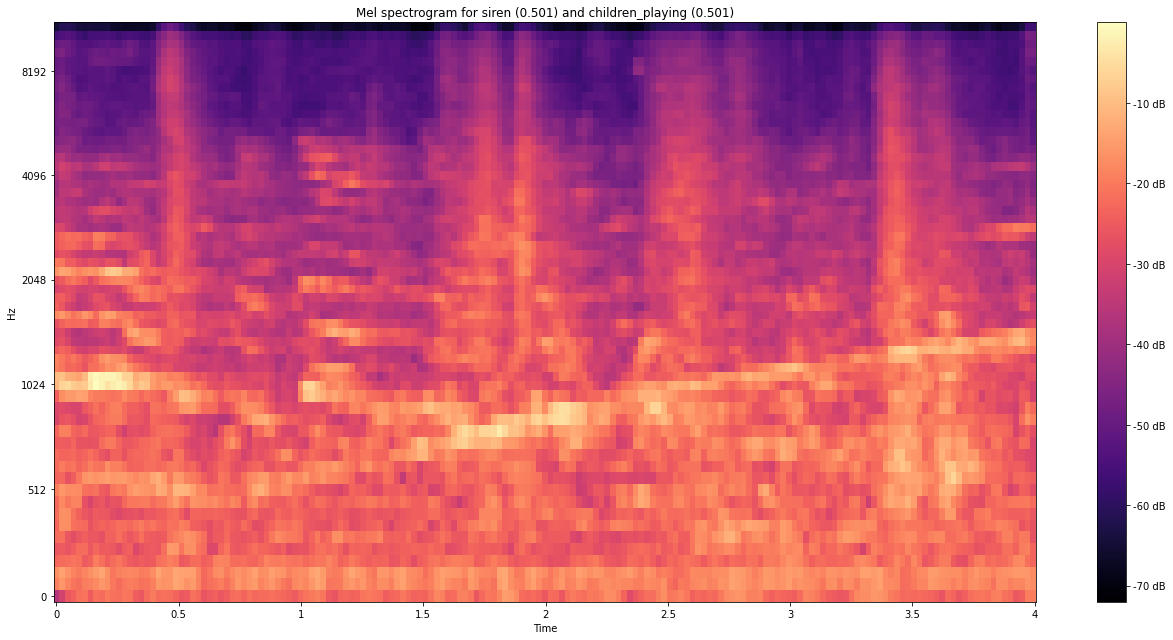

In [11]:
class_look_up_dict = {"air_conditioner": 0,"car_horn": 1,"children_playing": 2,"dog_bark": 3,"drilling": 4,"engine_idling": 5,
    "gun_shot": 6,"jackhammer": 7,"siren":8,"street_music": 9}

class_look_up = list(class_look_up_dict.keys())

audio = glob.glob(f'{dest_dir}{fold}/*.wav')[random.randint(0, 300)] #Random Audio spectrogram file selection for visualizations
file = audio.split('/')[-1][:-4]


y, sr = librosa.load(audio)
librosa.feature.melspectrogram(y=y, sr=sr)

D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=60)

plt.figure(figsize=(18, 9))
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+3.0f dB')
plt.title( f"Mel spectrogram for {class_look_up[int(file.split('-')[1][0])]} {file.split('-')[1][1:]} and {class_look_up[int(file.split('-')[2][0])]} {file.split('-')[2][1:8]}" )
plt.tight_layout()
plt.savefig(f'{file}.png')
plt.show()

# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:75%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Extract features into file (per fold and full)</div>

In [12]:
!mkdir /kaggle/working/multi-processed #making Directory
parent_dir = '/kaggle/working/multi'
feat_dir = "/kaggle/working/multi-processed"
folds = sub_dirs = np.array(['fold1','fold2','fold3','fold4',
                  'fold5','fold6','fold7','fold8',
                  'fold9','fold10'],dtype=object,)

for fold in folds:
    print(f'Processing files in: {fold}')
    features, labels = extract_features_audio(parent_dir, fold) # Pre-process and extract feature from the data (per fold)
    np.savez(f'{feat_dir}/{fold}', features=features, labels=labels)

Processing files in: fold1


  0%|          | 0/413 [00:00<?, ?it/s]

Processing files in: fold2


  0%|          | 0/423 [00:00<?, ?it/s]

Processing files in: fold3


  0%|          | 0/437 [00:00<?, ?it/s]

Processing files in: fold4


  0%|          | 0/464 [00:00<?, ?it/s]

Processing files in: fold5


  0%|          | 0/448 [00:00<?, ?it/s]

Processing files in: fold6


  0%|          | 0/391 [00:00<?, ?it/s]

Processing files in: fold7


  0%|          | 0/393 [00:00<?, ?it/s]

Processing files in: fold8


  0%|          | 0/383 [00:00<?, ?it/s]

Processing files in: fold9


  0%|          | 0/393 [00:00<?, ?it/s]

Processing files in: fold10


  0%|          | 0/396 [00:00<?, ?it/s]

# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:75%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Create single file on full dataset through appending for quick access</div>

In [13]:
!mkdir /kaggle/working/multi-processed/full_features
feat_dir = "/kaggle/working/multi-processed"
folds = sub_dirs = np.array(['fold1','fold2','fold3','fold4',
                  'fold5','fold6','fold7','fold8',
                  'fold9','fold10'],dtype=object,)
full_features = []
full_labels = []

for fold in folds:
    data = np.load(f'{feat_dir}/{fold}.npz', allow_pickle=True)
    features = data["features"]
    labels = data["labels"]
    full_features.append(features)
    full_labels.append(labels)
    
np.savez(f'{feat_dir}/full_features', features=full_features, labels=full_labels) # combined and saved

In [14]:
!ls '{feat_dir}' 

fold1.npz   fold2.npz  fold4.npz  fold6.npz  fold8.npz	full_features
fold10.npz  fold3.npz  fold5.npz  fold7.npz  fold9.npz	full_features.npz


# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:75%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Define architecture of CNN with Keras</div>

In [15]:
def Multi_Label_Audio_model():
    num_filters = [32, 32, 64, 128] 
    pool_size = (2, 2) 
    kernel_size = (3, 3) 
    input_shape = (60, 41, 2) # two layers for melspec and deltas of melspec
    num_classes = 10 # categories of sound
    keras.backend.clear_session()
    
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, kernel_size,
                padding="same", input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))

    model.add(keras.layers.Conv2D(32, kernel_size,
                                  padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
    
    model.add(keras.layers.Conv2D(64, kernel_size,
                                  padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu")) 
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
    
    model.add(keras.layers.Conv2D(128, kernel_size,
                                  padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))  

    model.add(keras.layers.GlobalMaxPooling2D())
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(num_classes, activation='sigmoid')) # sigmoid provides unconstrained probability distrib vs softmax

    model.compile(optimizer=keras.optimizers.Adam(1e-4), 
        loss='binary_crossentropy', # one-hot encoding for binary arrays
        metrics=["categorical_accuracy"]) # provides better estimates of accuracy for one-hot labels
    return model

# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:75%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Split data into training and test sets</div>

In [16]:
!mkdir /kaggle/working/models_24_05_2024

cp_path = "/kaggle/working/models_24_05_2024/checkpoint.hdf5"
checkpoint = ModelCheckpoint(cp_path, monitor='val_loss', verbose=15, save_best_only=True,mode='auto', save_freq='epoch')
load_dir = "/kaggle/working/multi-processed"

data = np.load("{0}/{1}.npz".format(load_dir,'full_features'),
                allow_pickle=True)

features = np.concatenate(data["features"], axis = 0)
labels = np.concatenate(data["labels"], axis = 0)

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=.5)

x_train = np.concatenate(x_train, axis = 0).astype(np.float32)
y_train = np.concatenate(y_train, axis = 0).astype(np.float32)

# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:75%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Encode labels as one-hot binary arrays</div>

In [17]:
mlb = MultiLabelBinarizer()
mlb.fit([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]) # fit mlb to the category range

y_tr_array = np.array(y_train, dtype=object,)
y_tr_hot = mlb.transform(y_tr_array) # this can be done because multi one-hot arrays are not needed (as they are when comparing test to predict)

y_te_hot = []
for y in y_test: # for each window sample of one sound file in test set
    y_te_array = np.array(y , dtype=object,)
    y_hot = mlb.transform(y_te_array) # encoding with transform
    y_te_hot.append(y_hot)
y_te_hot = np.array(y_te_hot, dtype=object,)

# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:75%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Train model and present performance</div>

In [18]:
wandb.init()

In [19]:
# strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"]) #Setting Up the strategy for 2 GPUS utilizations
# with strategy.scope():
model = Multi_Label_Audio_model()


history = model.fit(x_train, y_tr_hot, epochs = 100,validation_data=zip(x_test, y_te_hot),validation_freq=[0, 10, 20, 30, 40, 50,60, 70, 80, 90], batch_size = 16, verbose = 1,callbacks=[checkpoint,WandbMetricsLogger(log_freq=15)])

model.save('/kaggle/working/models_24_05_2024/models-multi-%s' % time.time()) 

Epoch 1/100
802/802 [==============================] - 14s 5ms/step - loss: 0.4282 - categorical_accuracy: 0.2560
Epoch 2/100
802/802 [==============================] - 4s 5ms/step - loss: 0.3716 - categorical_accuracy: 0.3139
Epoch 3/100
802/802 [==============================] - 4s 5ms/step - loss: 0.3480 - categorical_accuracy: 0.3427
Epoch 4/100
802/802 [==============================] - 4s 5ms/step - loss: 0.3274 - categorical_accuracy: 0.3690
Epoch 5/100
802/802 [==============================] - 4s 5ms/step - loss: 0.3087 - categorical_accuracy: 0.3891
Epoch 6/100
802/802 [==============================] - 4s 5ms/step - loss: 0.2926 - categorical_accuracy: 0.4089
Epoch 7/100
802/802 [==============================] - 4s 5ms/step - loss: 0.2765 - categorical_accuracy: 0.4150
Epoch 8/100
802/802 [==============================] - 4s 5ms/step - loss: 0.2613 - categorical_accuracy: 0.4289
Epoch 9/100
802/802 [==============================] - 4s 5ms/step - loss: 0.2481 - categorical

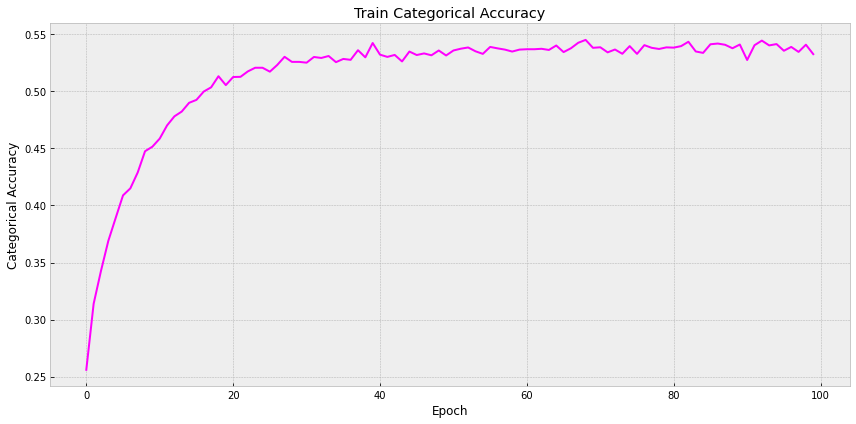

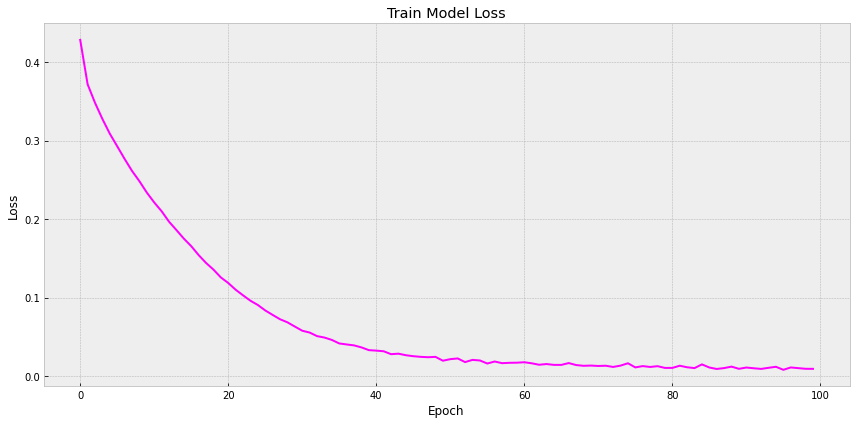

In [20]:
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['categorical_accuracy'] ,'magenta')
    plt.title('Train Categorical Accuracy')
    plt.ylabel('Categorical Accuracy')
    plt.xlabel('Epoch')
    plt.tight_layout()

    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'] ,'magenta')
    plt.title('Train Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.tight_layout()

    # plt.savefig('loss.png')
    plt.show()



# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:75%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Load pre-trained model for testing</div>

In [21]:
glob.glob('models_24_05_2024/*')

['models_24_05_2024/checkpoint.hdf5',
 'models_24_05_2024/models-multi-1716585484.3489418']

In [22]:
model = tf.keras.models.load_model(glob.glob('models_24_05_2024/*')[0])

# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:75%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Test model performance with performance metrics</div>

In [23]:
y_true, y_pred = [], []

print('Evaluating on test set...')
for x, y in zip(x_test, y_te_hot):
    # average predictions over segments of a sound clip
    pred = model.predict(x)
    avg_p = np.unique(np.argmax(pred, axis=1)) # avg predictions of each array
    hot_p = mlb.transform([avg_p]) # convert to one-hot encoding - no idea why it wont pass without brackets 

    # print(f'Predict: {hot_p}')
    y_pred.append(hot_p[0]) 
    
    # print(f'True: {y[0]}') 
    y_true.append(y[0]) # pick single label for a sound clip (they're all identical)

hamming = hamming_loss(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
     
print(f'Average Accuracy: {accuracy}')
print(f'Average Hamming: {hamming}\n')
print(f'{multilabel_confusion_matrix(y_true, y_pred)}\n')
print(classification_report(y_true, y_pred))

Evaluating on test set...
Average Accuracy: 0.1717019133937563
Average Hamming: 0.16017119838872104

[[[1392  143]
  [ 236  215]]

 [[1800   20]
  [  61  105]]

 [[1435  137]
  [ 275  139]]

 [[1306  253]
  [ 137  290]]

 [[1459   92]
  [ 188  247]]

 [[1315  242]
  [ 122  307]]

 [[1833    8]
  [  95   50]]

 [[1114  446]
  [  61  365]]

 [[1359  223]
  [ 105  299]]

 [[1422  121]
  [ 216  227]]]

              precision    recall  f1-score   support

           0       0.60      0.48      0.53       451
           1       0.84      0.63      0.72       166
           2       0.50      0.34      0.40       414
           3       0.53      0.68      0.60       427
           4       0.73      0.57      0.64       435
           5       0.56      0.72      0.63       429
           6       0.86      0.34      0.49       145
           7       0.45      0.86      0.59       426
           8       0.57      0.74      0.65       404
           9       0.65      0.51      0.57       443

  

In [24]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               batch/batch_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:     batch/categorical_accuracy ▁▃▄▅▅█▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇███▇▇▇▇█▇▇▇█▇▇
wandb:            batch/learning_rate ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     batch/loss █▇▆▅▅▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
wandb:     epoch/categorical_accuracy ▁▃▅▅▆▆▇▇▇▇▇█████████████████████████████
wandb:                    epoch/epoch ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:            epoch/learning_rate ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                     epoch/loss █▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: epoch/val_categorical_accuracy ▁
wandb:                 epoch/val_loss ▁
wandb: 
wandb: Run summary:
wandb:               batch/batch_step 80985
wandb:     batch/categorical_accuracy 0.53204
wandb:            batch/learning_rate 0.0001
wandb:    

# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:75%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">Predicting on new data(FOLD 10)</div>

In [25]:
parent_dir = '/kaggle/input/urbansound8k/'
sub_dir = 'fold10' # directory for unseen samples
test_files = [fn for fn in os.listdir(parent_dir+sub_dir) if fn.endswith('.wav')][0:10]

print('\nPredicting!')
features, labels = extract_features_audio(parent_dir, sub_dir)

predictions = []
for x in features:
    pred = model.predict(x)
    avg_p = np.unique(np.argmax(pred, axis=1))
    predictions.append(avg_p)

print('\nPredictions')
for fn, pred in zip(test_files, predictions):
    print(f'File: {fn} -> Prediction category: {pred}')
    [print(class_look_up[i]) for i in pred]


Predicting!


  0%|          | 0/837 [00:00<?, ?it/s]

Unseen sample /kaggle/input/urbansound8k/fold10/136558-9-1-21.wav
Unseen sample /kaggle/input/urbansound8k/fold10/174289-6-3-0.wav
Unseen sample /kaggle/input/urbansound8k/fold10/165640-4-0-1.wav
Unseen sample /kaggle/input/urbansound8k/fold10/207213-2-0-52.wav
Unseen sample /kaggle/input/urbansound8k/fold10/99192-4-0-43.wav
Unseen sample /kaggle/input/urbansound8k/fold10/117889-9-0-12.wav
Unseen sample /kaggle/input/urbansound8k/fold10/162134-7-1-0.wav
Unseen sample /kaggle/input/urbansound8k/fold10/188813-7-0-0.wav
Unseen sample /kaggle/input/urbansound8k/fold10/162134-7-8-2.wav
Unseen sample /kaggle/input/urbansound8k/fold10/172519-9-0-49.wav
Unseen sample /kaggle/input/urbansound8k/fold10/141240-5-1-0.wav
Unseen sample /kaggle/input/urbansound8k/fold10/93567-8-0-12.wav
Unseen sample /kaggle/input/urbansound8k/fold10/171478-9-0-57.wav
Unseen sample /kaggle/input/urbansound8k/fold10/59513-3-0-4.wav
Unseen sample /kaggle/input/urbansound8k/fold10/88121-8-0-3.wav
Unseen sample /kaggle/

In [26]:
%%capture

!curl -O http://www.fsnradionews.com/FSNNews/FSNHeadlines.mp3 -A "Mozilla/4.0"
!ffmpeg -i FSNHeadlines.mp3 FSNHeadlines.wav 

In [27]:
ls

 FSNHeadlines.mp3    'comb-8(0.501)-2(0.501).png'   multi-processed/
 FSNHeadlines.wav     models_24_05_2024/            wandb/
 __notebook__.ipynb   multi/


In [28]:
def extract_features_single_audio(audio_path, file_ext="*.wav", bands=60, frames=41):
    def _windows(data, window_size):
        start = 0
        while start < len(data):
            yield int(start), int(start + window_size)
            start += (window_size // 2)
        
    feature, segment_log_specgrams = [], []    
    window_size = 512 * (frames - 1) # size of sliding window for taking multiple samples of each sound, could be extended
    sound_clip, xsr = librosa.load(audio_path)
    for (start,end) in _windows(sound_clip,window_size):
        if(len(sound_clip[start:end]) == window_size):
            signal = sound_clip[start:end]
            melspec = librosa.feature.melspectrogram(y=signal, n_mels=bands) # extracting melspec with 60 bands
            logspec = librosa.amplitude_to_db(melspec)  # converting to log scale
            logspec = logspec.T.flatten()[:, np.newaxis].T
            segment_log_specgrams.append(logspec)
    segment_log_specgrams = np.asarray(segment_log_specgrams).reshape(
    len(segment_log_specgrams),bands,frames,1) # reshape to (60, 41, 1)
    segment_features = np.concatenate((segment_log_specgrams, np.zeros(
    np.shape(segment_log_specgrams))), axis=3) # add one layer to axis -> (60, 40, 2)
    for i in range(len(segment_features)): 
        segment_features[i, :, :, 1] = librosa.feature.delta(
            segment_features[i, :, :, 0]) # extract deltas into new layer

    if len(segment_features) > 0: # check for empty segments 
        feature.append(segment_features)
            
    return feature

In [29]:
feature = extract_features_single_audio(audio_path = "FSNHeadlines.wav")
pred = model.predict(feature)
pred = np.unique(np.argmax(pred, axis=1))
p = [print(class_look_up[i]) for i in pred]

children_playing
dog_bark
gun_shot
street_music


# <div style="padding:20px;color:#f0f2f0;margin:0;font-size:80%;text-align:center;display:fill;border-radius:5px;background-color:#1a0a36;overflow:hidden">References</div>


<ol style="display: block;list-style-type: decimal;font-weight: 500; margin-block-start: 1em;margin-block-end: 1em;margin-inline-start: 0px; margin-inline-end: 0px;padding-inline-start: 40px;color: #666">
    
<li>
<p style="display: block;list-style-type: decimal;font-weight: 500; margin-block-start: 1em;margin-block-end: 1em;margin-inline-start: 0px; margin-inline-end: 0px;padding-inline-start: 40px;color: #666">Abdoli, S., Cardinal, P., &amp; Koerich, A. L. (2019). End-to-End Environmental Sound Classification using a 1D Convolutional Neural Network. ArXiv:1904.08990 [Cs, Stat]. <a href="https://arxiv.org/abs/1904.08990">http://arxiv.org/abs/1904.08990</a></p>
</li>
<li>
<p style="display: block;list-style-type: decimal;font-weight: 500; margin-block-start: 1em;margin-block-end: 1em;margin-inline-start: 0px; margin-inline-end: 0px;padding-inline-start: 40px;color: #666">Mushtaq, Z., &amp; Su, S.-F. (2020). Environmental sound classification using a regularized deep convolutional neural network with data augmentation. Applied Acoustics, 167, 107389. <a href="https://doi.org/10.1016/j.apacoust.2020.107389">https://doi.org/10.1016/j.apacoust.2020.107389</a></p>
</li>
<li>
<p style="display: block;list-style-type: decimal;font-weight: 500; margin-block-start: 1em;margin-block-end: 1em;margin-inline-start: 0px; margin-inline-end: 0px;padding-inline-start: 40px;color: #666">Piczak, K. J. (2020). Karolpiczak/ESC-50 [Python]. <a href="https://github.com/karolpiczak/ESC-50">https://github.com/karolpiczak/ESC-50</a> (Original work published 2015)</p>
</li>
<li>
<p style="display: block;list-style-type: decimal;font-weight: 500; margin-block-start: 1em;margin-block-end: 1em;margin-inline-start: 0px; margin-inline-end: 0px;padding-inline-start: 40px;color: #666">Piczak, K. J. (2015a). Environmental sound classification with convolutional neural networks. 2015 IEEE 25th International Workshop on Machine Learning for Signal Processing (MLSP), 1–6. <a href="https://doi.org/10.1109/MLSP.2015.7324337">https://doi.org/10.1109/MLSP.2015.7324337</a></p>
</li>
<li>
<p style="display: block;list-style-type: decimal;font-weight: 500; margin-block-start: 1em;margin-block-end: 1em;margin-inline-start: 0px; margin-inline-end: 0px;padding-inline-start: 40px;color: #666">Piczak, K. J. (2015b). ESC: Dataset for Environmental Sound Classification. Proceedings of the 23rd ACM International Conference on Multimedia, 1015–1018. <a href="https://doi.org/10.1145/2733373.2806390">https://doi.org/10.1145/2733373.2806390</a></p>
</li>
<li>
<p style="display: block;list-style-type: decimal;font-weight: 500; margin-block-start: 1em;margin-block-end: 1em;margin-inline-start: 0px; margin-inline-end: 0px;padding-inline-start: 40px;color: #666">Saeed, A. (n.d.). Urban Sound Classification, Part 2. Retrieved 18 September 2020, from <a href="https://aqibsaeed.github.io/2016-09-24-urban-sound-classification-part-2/">http://aqibsaeed.github.io/2016-09-24-urban-sound-classification-part-2/</a></p>
</li>
<li>
<p>Aaqib. (2020). Aqibsaeed/Urban-Sound-Classification [Jupyter Notebook]. <a href="https://github.com/aqibsaeed/Urban-Sound-Classification">https://github.com/aqibsaeed/Urban-Sound-Classification</a> (Original work published 2016)</p>
</li>
<li>
<p style="display: block;list-style-type: decimal;font-weight: 500; margin-block-start: 1em;margin-block-end: 1em;margin-inline-start: 0px; margin-inline-end: 0px;padding-inline-start: 40px;color: #666">Su, Y., Zhang, K., Wang, J., &amp; Madani, K. (2019). Environment Sound Classification Using a Two-Stream CNN Based on Decision-Level Fusion. Sensors, 19(7), 1733. <a href="https://doi.org/10.3390/s19071733">https://doi.org/10.3390/s19071733</a></p>
</li>
<li>
<p style="display: block;list-style-type: decimal;font-weight: 500; margin-block-start: 1em;margin-block-end: 1em;margin-inline-start: 0px; margin-inline-end: 0px;padding-inline-start: 40px;color: #666">UrbanSound8K. (n.d.). Urban Sound Datasets. Retrieved 23 August 2020, from <a href="https://urbansounddataset.weebly.com/urbansound8k.html">https://urbansounddataset.weebly.com/urbansound8k.html</a></p>
</li>
</ol>